# Multiple-Strain Model of COVID and Vaccines

In [1]:
using AlgebraicPetri, AlgebraicPetri.TypedPetri
using Catlab.Programs, Catlab.Graphics
using Catlab.CategoricalAlgebra
using Catlab.WiringDiagrams
using DisplayAs, Markdown

This example presents models incorporating multiple strains of disease and vaccine type.
Importantly, it shows why stratification by disease strain is different from other stratifications, e.g. geography or age, and requires using a different type system.

## Define basic epidemiology model

We start by defining our basic type system for infectious disease models.

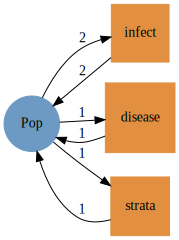

In [2]:
const infectious_ontology = LabelledPetriNet(
  [:Pop],
  :infect => ((:Pop, :Pop) => (:Pop, :Pop)),
  :disease => (:Pop => :Pop),
  :strata => (:Pop => :Pop)
)

to_graphviz(infectious_ontology)

We define a simple SIRD model with reflexive transitions typed as `:strata` to indicate which states can be stratified.
Here we add reflexive transitions to the susceptible, infected, and recovered populations but we leave out the dead
population because they cannot do things such as get vaccinated or travel between regions.

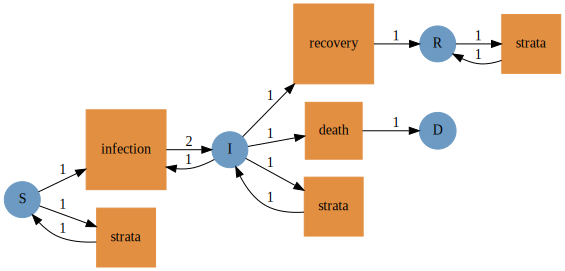

In [3]:
sird_uwd = @relation (S,I,R,D) where (S::Pop, I::Pop, R::Pop, D::Pop) begin
  infect(S, I, I, I)
  disease(I, R)
  disease(I, D)
end

sird_model = oapply_typed(infectious_ontology, sird_uwd, [:infection, :recovery, :death])
sird_model = add_reflexives(sird_model, [[:strata], [:strata], [:strata], []], infectious_ontology)

to_graphviz(dom(sird_model))

## Define a model of multiple vaccine types

We also define a model of vaccination with multiple vaccine types.
In this model, vaccination transitions are typed as `:strata`.
Note that the `:infect` transitions must be included to enable cross-infection between different vax types.

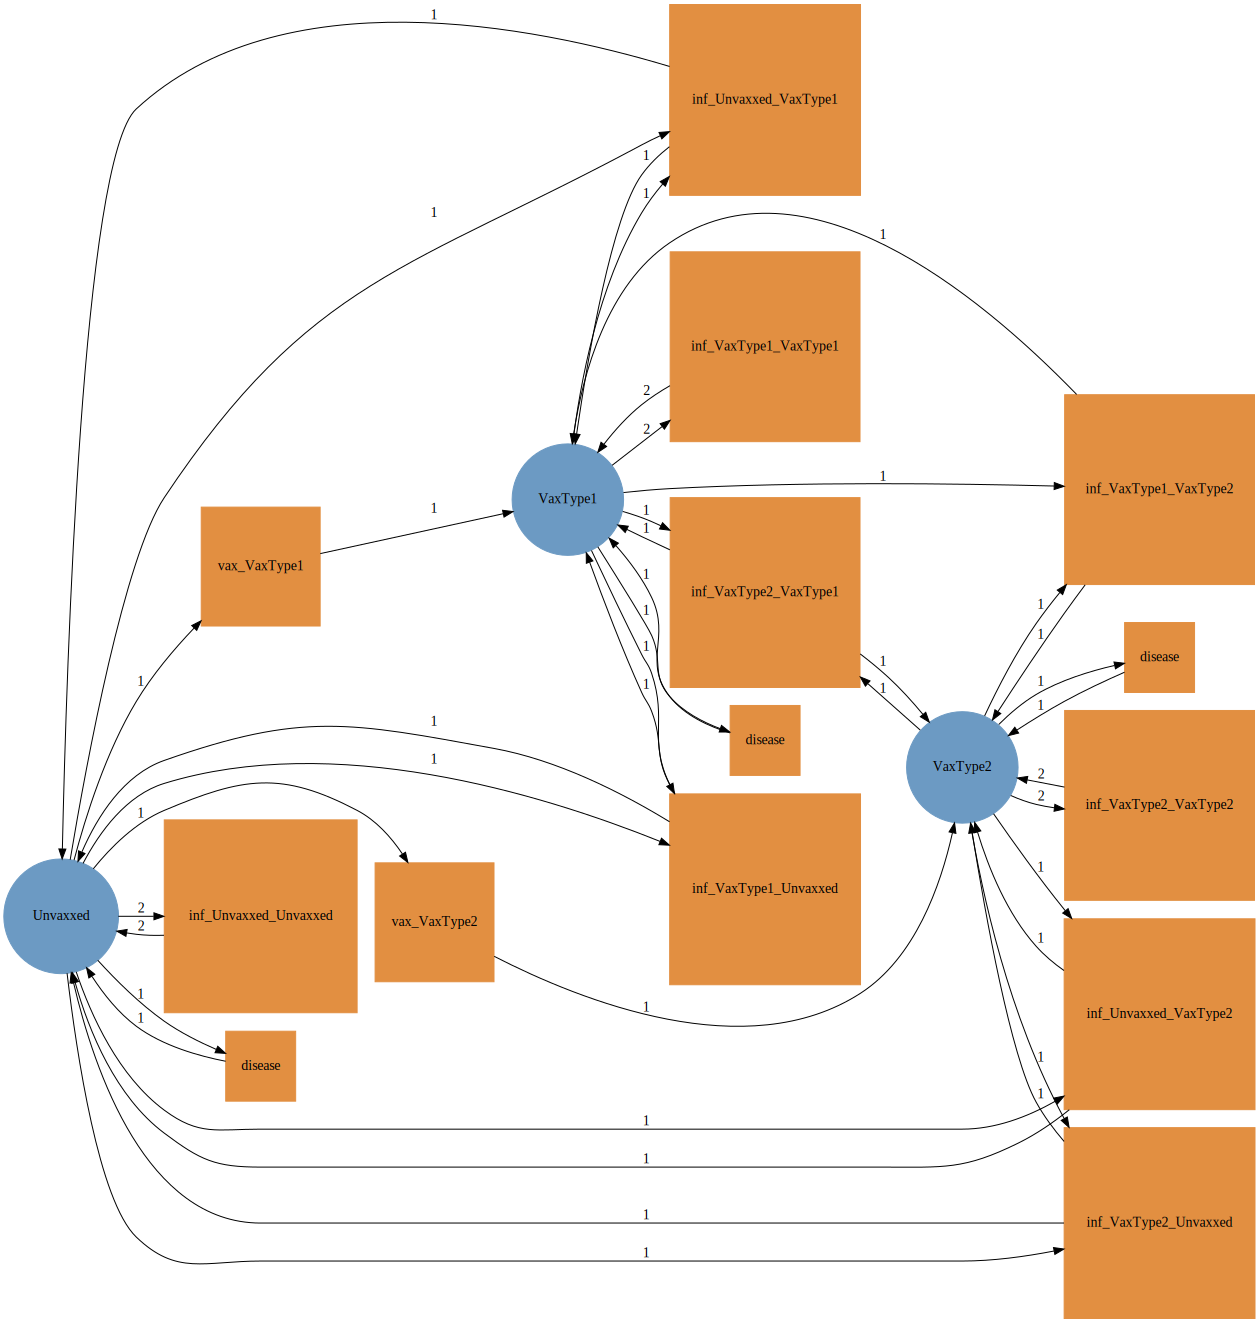

In [4]:
function vax_model(n)
  uwd = RelationDiagram(repeat([:Pop], n+1))

  variable = :Unvaxxed
  junction = add_junction!(uwd, :Pop, variable=variable)
  port = ports(uwd, outer=true)[1]
  set_junction!(uwd, port, junction, outer=true)
  junctions = Dict(variable => junction)
  for i in 1:n
    variable = Symbol("VaxType$(i)")
    junction = add_junction!(uwd, :Pop, variable=variable)
    port = ports(uwd, outer=true)[i+1]
    set_junction!(uwd, port, junction, outer=true)
    junctions[variable] = junction
  end

  strains = filter((x) -> x != Symbol("Unvaxxed"), keys(junctions))
  for s in strains
    pair = (:Unvaxxed, s)
    box = add_box!(uwd, [junction_type(uwd, junctions[p]) for p in pair], name=:strata)
    for (rgn, port) in zip(pair, ports(uwd, box))
      set_junction!(uwd, port, junctions[rgn])
    end
  end
  tnames = [Symbol("vax_$(b)") for b in strains]

  pairs = collect(Iterators.product(keys(junctions), keys(junctions)))
  for pair in pairs
    ins_outs = (pair[1], pair[2], pair[1], pair[2])
    box = add_box!(uwd, [junction_type(uwd, junctions[p]) for p in ins_outs], name=:infect)
    for (rgn, port) in zip(ins_outs, ports(uwd, box))
      set_junction!(uwd, port, junctions[rgn])
    end
    push!(tnames,Symbol("inf_$(pair[1])_$(pair[2])"))
  end
  act = oapply_typed(infectious_ontology, uwd, tnames)
  add_reflexives(act, repeat([[:disease]], n+1), infectious_ontology)
end

to_graphviz(dom(vax_model(2)))

## Stratify the SIRD model with vaccinations for two vaccine types

We can now stratify the two typed models to get a model of SIRD with vaccination by multiple possible vaccine types.

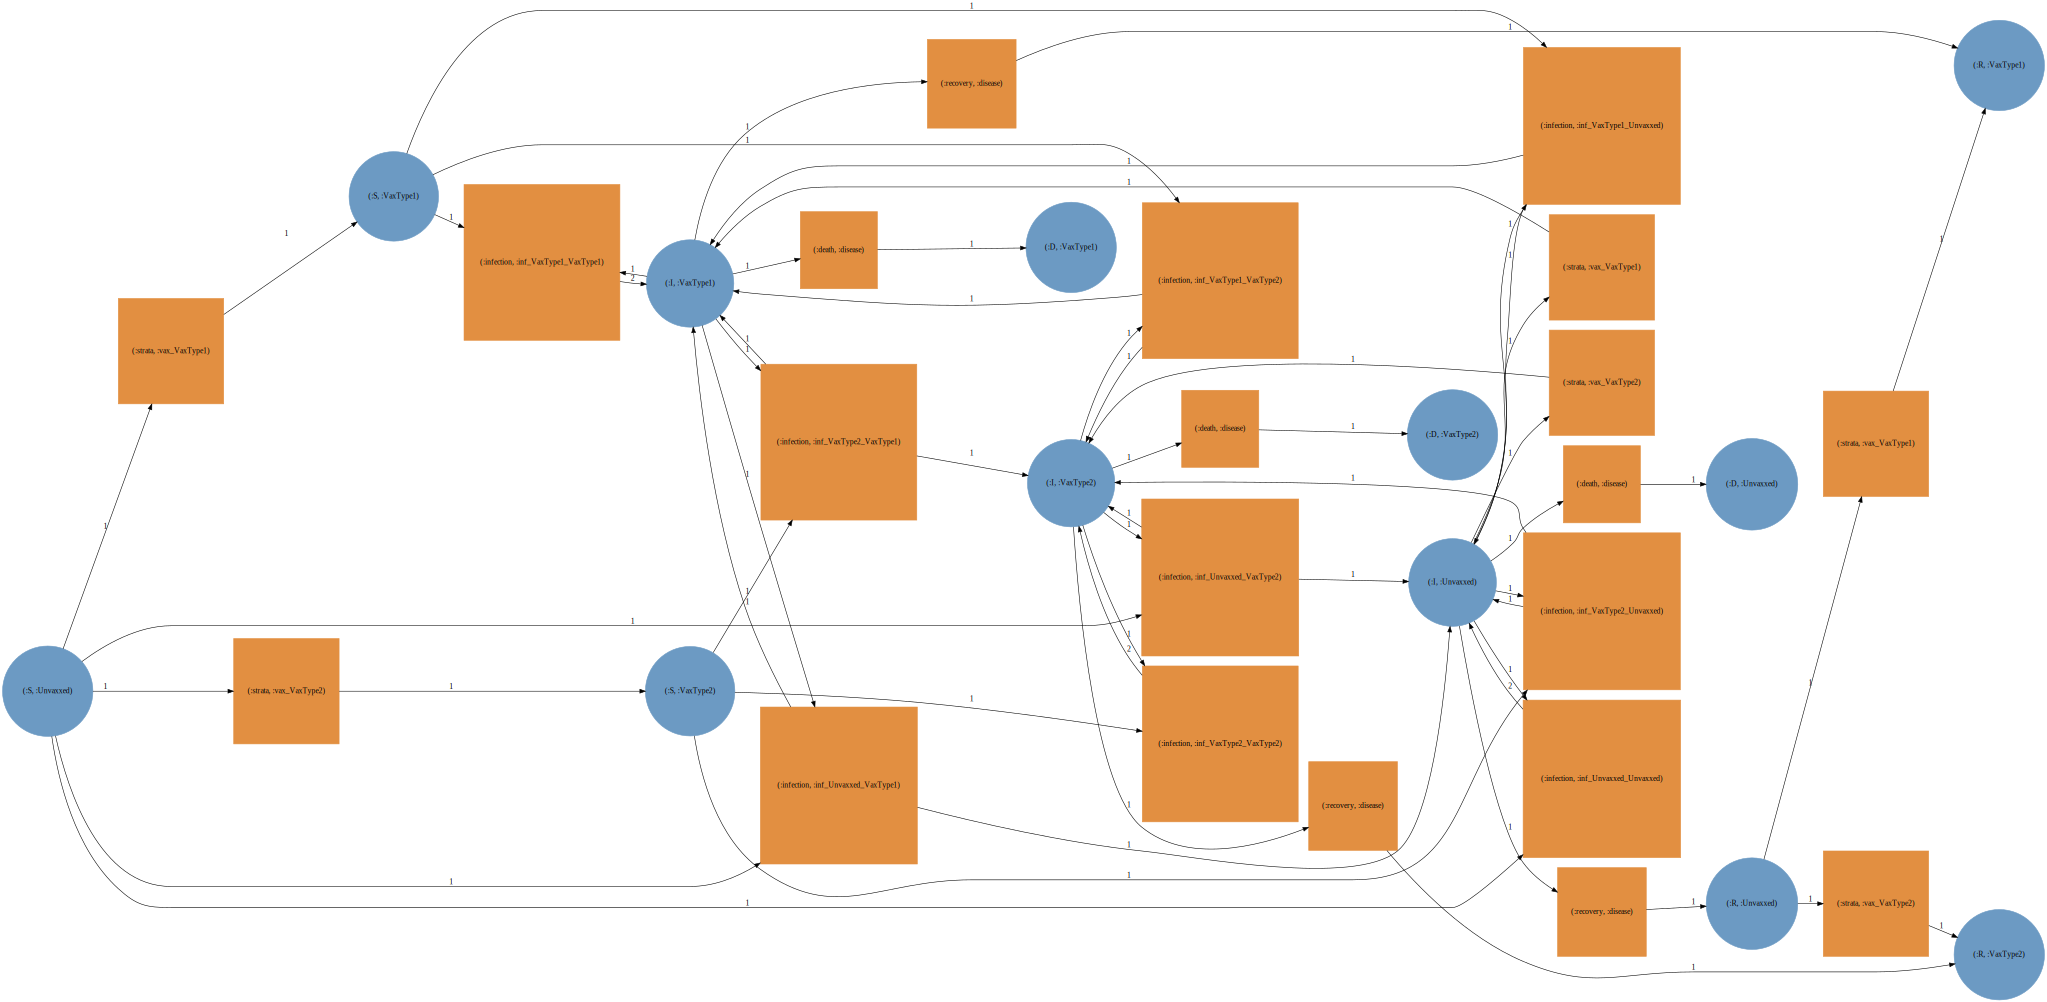

In [5]:
typed_product(sird_model, vax_model(2)) |> dom |> to_graphviz

## Define a model of multiple disease strains

Here we define a model of multiple strains of disease infection.
In this model, uninfected individuals can become infected by indivuals carrying one of the strains.
This model can be typed  the `infectious_ontology`.
We add reflexives of `:disease` and `:strata` for the strain states but only `:strata` for the uninfected state.

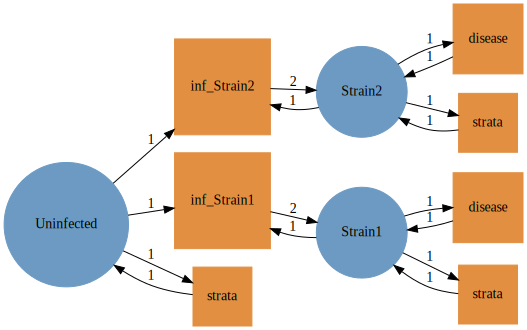

In [6]:
function strain_model′(n)
  uwd = RelationDiagram(repeat([:Pop], n+1))
  variable = :Uninfected
  junction = add_junction!(uwd, :Pop, variable=variable)
  port = ports(uwd, outer=true)[1]
  set_junction!(uwd, port, junction, outer=true)
  junctions = Dict(variable => junction)
  for i in 1:n
    variable = Symbol("Strain$(i)")
    junction = add_junction!(uwd, :Pop, variable=variable)
    port = ports(uwd, outer=true)[i+1]
    set_junction!(uwd, port, junction, outer=true)
    junctions[variable] = junction
  end
  strains = filter((x) -> x != Symbol("Uninfected"), keys(junctions))
  for s in strains
    pair = (:Uninfected, s, s, s)
    box = add_box!(uwd, [junction_type(uwd, junctions[p]) for p in pair], name=:infect)
    for (rgn, port) in zip(pair, ports(uwd, box))
      set_junction!(uwd, port, junctions[rgn])
    end
  end
  act = oapply_typed(infectious_ontology, uwd, [Symbol("inf_$(b)") for b in strains])
  add_reflexives(act, vcat([[:strata]],repeat([[:disease,:strata]], n)), infectious_ontology)
end

to_graphviz(dom(strain_model′(2)))

## Stratify the SIRD model for two strains

Unfortunately, stratification of these models does not produce the desired result.
There are quite a few extraneous states and transitions.
The primary issue is the asymmetry in the role of the uninfected population.
We can address this by changing the type system.

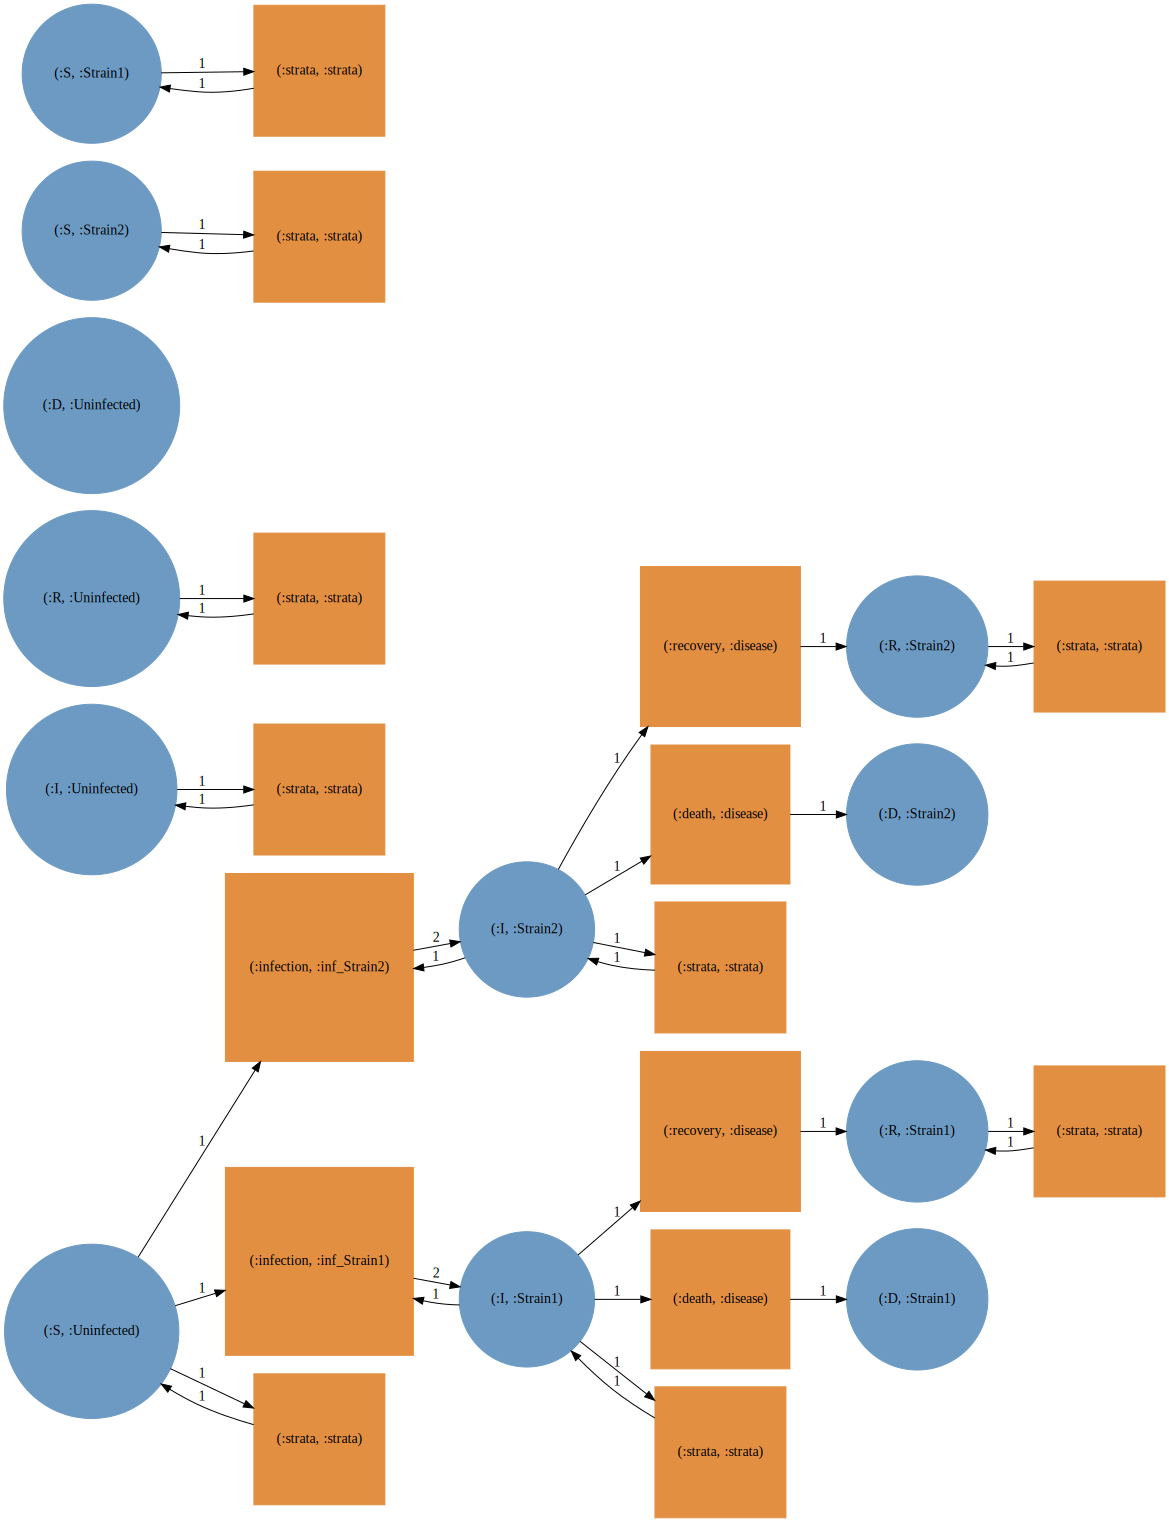

In [7]:
typed_product(sird_model, strain_model′(2)) |> dom |> to_graphviz

## Define a new type system and corresponding disease and multi-strain models

The new type system has separate states for uninfected and infected to account for the asymmetry in their role in infection
and for the corresponding asymmetry in the intended stratification.
Accordingly, the `:Inf` state has `:disease` and `:strataI` transitions.
The `:Uninf` state only has an additional "strata" transition, `:strataU`, but note this transition is distinct from that for the `:Inf` state.

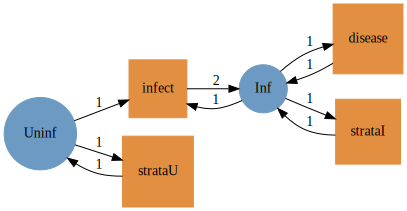

In [8]:
const strain_ontology = LabelledPetriNet(
  [:Uninf, :Inf],
  :infect => ((:Uninf, :Inf) => (:Inf, :Inf)),
  :disease => (:Inf => :Inf),
  :strataI => (:Inf => :Inf),
  :strataU => (:Uninf => :Uninf)
)

to_graphviz(strain_ontology)

We now reform the SIRD model using the new type system.

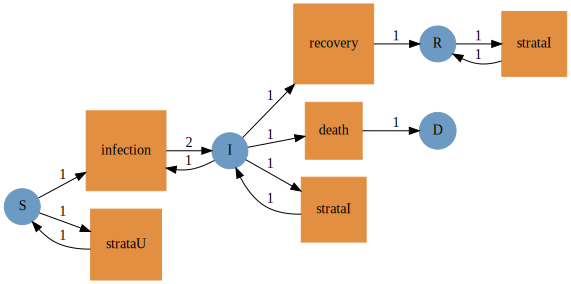

In [9]:
sird_for_strains_uwd = @relation (S,I,R,D) where (S::Uninf, I::Inf, R::Inf, D::Inf) begin
  infect(S, I, I, I)
  disease(I, R)
  disease(I, D)
end
sird_for_strains_model = oapply_typed(strain_ontology, sird_for_strains_uwd, [:infection, :recovery, :death])
sird_for_strains_model = add_reflexives(sird_for_strains_model, [[:strataU], [:strataI], [:strataI], []], strain_ontology)

to_graphviz(dom(sird_for_strains_model))

And similarly reform the multi-strain model.

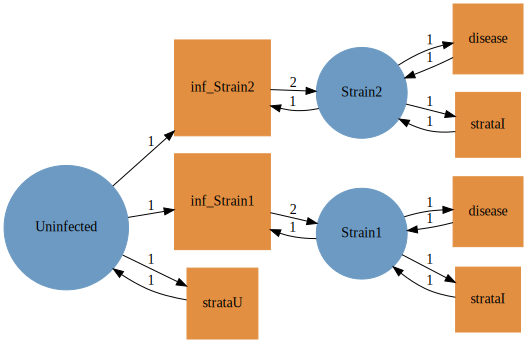

In [10]:
function strain_model(n)
  uwd = RelationDiagram(vcat([:Uninf],repeat([:Inf], n)))
  variable = :Uninfected
  junction = add_junction!(uwd, :Uninf, variable=variable)
  port = ports(uwd, outer=true)[1]
  set_junction!(uwd, port, junction, outer=true)
  junctions = Dict(variable => junction)
  for i in 1:n
    variable = Symbol("Strain$(i)")
    junction = add_junction!(uwd, :Inf, variable=variable)
    port = ports(uwd, outer=true)[i+1]
    set_junction!(uwd, port, junction, outer=true)
    junctions[variable] = junction
  end
  strains = filter((x) -> x != Symbol("Uninfected"), keys(junctions))
  for s in strains
    pair = (:Uninfected, s, s, s)
    box = add_box!(uwd, [junction_type(uwd, junctions[p]) for p in pair], name=:infect)
    for (rgn, port) in zip(pair, ports(uwd, box))
      set_junction!(uwd, port, junctions[rgn])
    end
  end
  act = oapply_typed(strain_ontology, uwd, [Symbol("inf_$(b)") for b in strains])
  add_reflexives(act, vcat([[:strataU]],repeat([[:disease,:strataI]], n)), strain_ontology)
end

to_graphviz(dom(strain_model(2)))

When we now stratify we get the desired model.

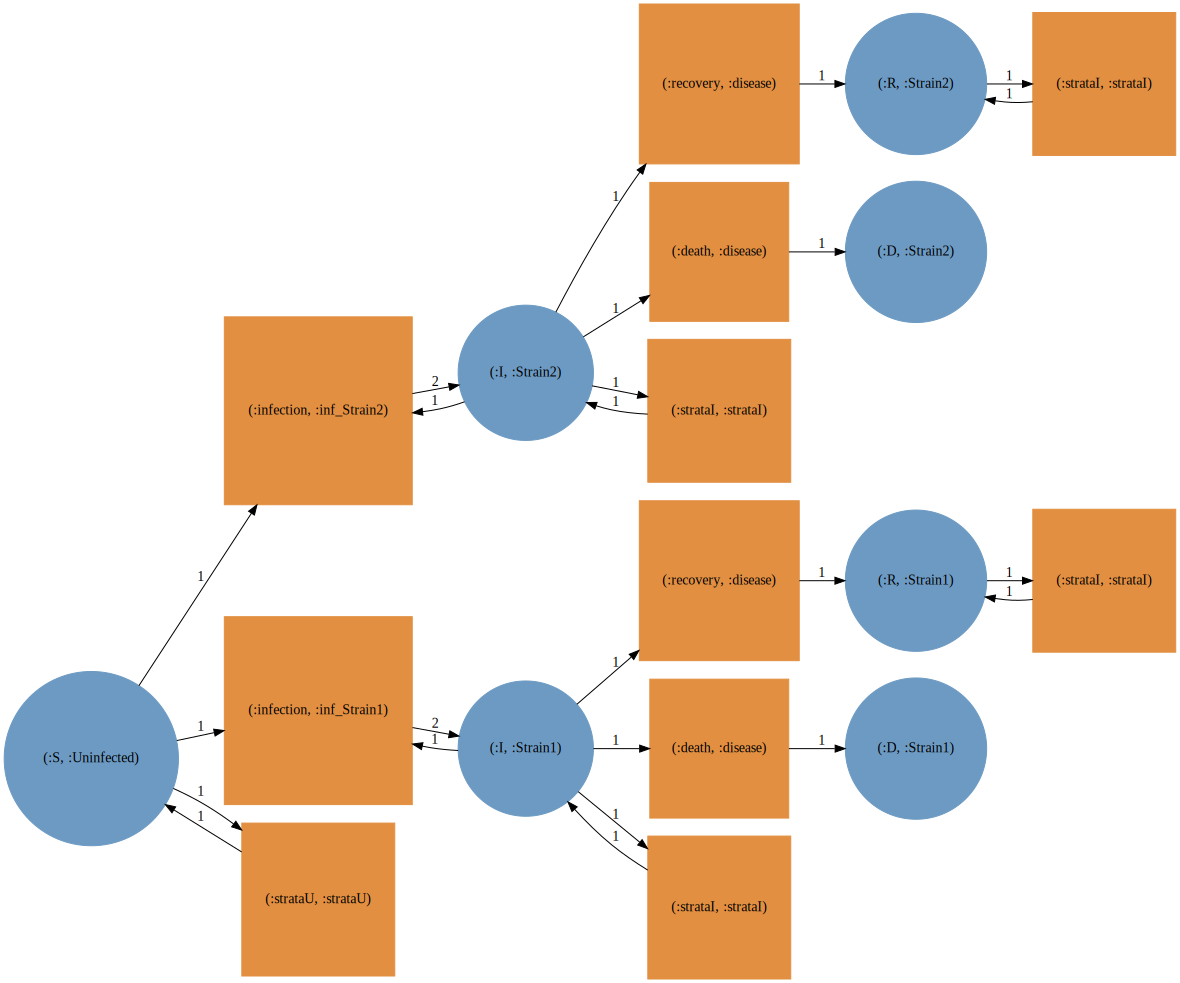

In [11]:
sird_strain = typed_product(sird_for_strains_model, strain_model(2))

to_graphviz(dom(sird_strain))

## Post-composition: Typing the type system

In some instances, we may want to relate models typed to different type systems.
For example, we usually type our `simple_trip` model of geographic regions to the `infectious_ontology` such that we can stratify a disease model by geographic regions,
but the multi-strain disease model above is typed by the new `strain_ontology`.

Crucially, we can accomplish this IF there is an appropriate morphism (map) between the type systems because post-composition by a morphism of type systems is functorial.
In this case, there is a morphism from `strain_ontology` to `infectious_ontology`, so we can form the morphism

### Morphism from `strain_ontology` to `infectious_ontology`

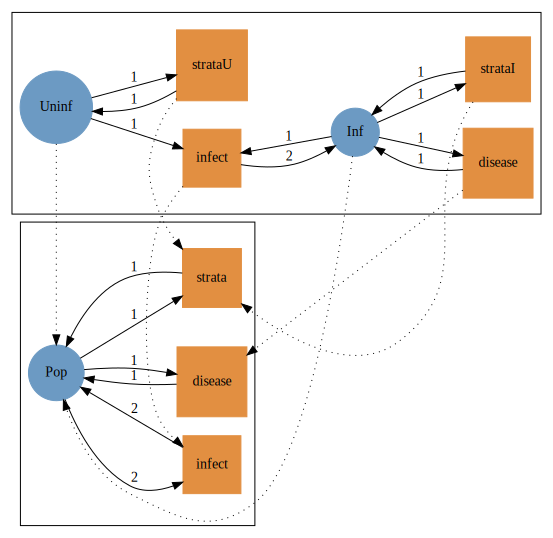

In [12]:
strain_ont_uwd = @relation (Uninf,Inf) where (Uninf::Pop, Inf::Pop) begin
  infect(Uninf, Inf, Inf, Inf)
  disease(Inf, Inf)
  strata(Inf, Inf)
  strata(Uninf, Uninf)
end
strain_ont_act = oapply_typed(infectious_ontology,strain_ont_uwd,[:infect,:disease,:strataI,:strataU])

to_graphviz(strain_ont_act)

### Define simple-trip geographic model of $N$ regions

To demonstrate stratification utilizing post-composition to re-type the models, we use the simple-trip geographic model.
This model is comprises a travel model and a living model.

**Travel model between $N$ regions**\n
In this model, there are $N$ regions which people can travel between. People within the same region are able
to infect other people in the same region.

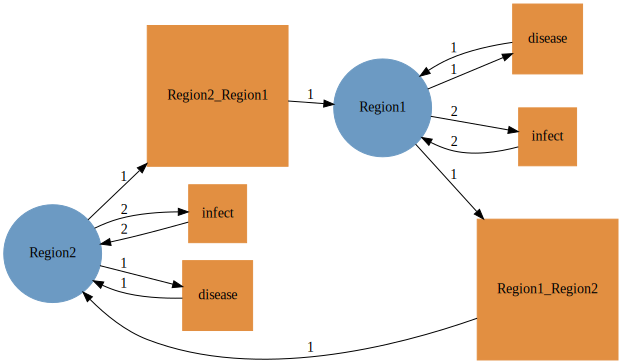

In [13]:
function travel_model(n)
  uwd = RelationDiagram(repeat([:Pop], n))
  junctions = Dict(begin
    variable = Symbol("Region$(i)")
    junction = add_junction!(uwd, :Pop, variable=variable)
    set_junction!(uwd, port, junction, outer=true)
    variable => junction
  end for (i, port) in enumerate(ports(uwd, outer=true)))

  pairs = filter(x -> first(x) != last(x), collect(Iterators.product(keys(junctions), keys(junctions))))
  for pair in pairs
    box = add_box!(uwd, [junction_type(uwd, junctions[p]) for p in pair], name=:strata)
    for (rgn, port) in zip(pair, ports(uwd, box))
      set_junction!(uwd, port, junctions[rgn])
    end
  end

  act = oapply_typed(infectious_ontology, uwd, [Symbol("$(a)_$(b)") for (a, b) in pairs])
  add_reflexives(act, repeat([[:infect, :disease]], n), infectious_ontology)
end

to_graphviz(dom(travel_model(2)))

This model could itself be stratified with the SIRD model, but we want to model
persons travelling between locations while maintaining the status of where they live.

**Living model of $N$ regions**\n
In this model, people have the property of "Living" somewhere.

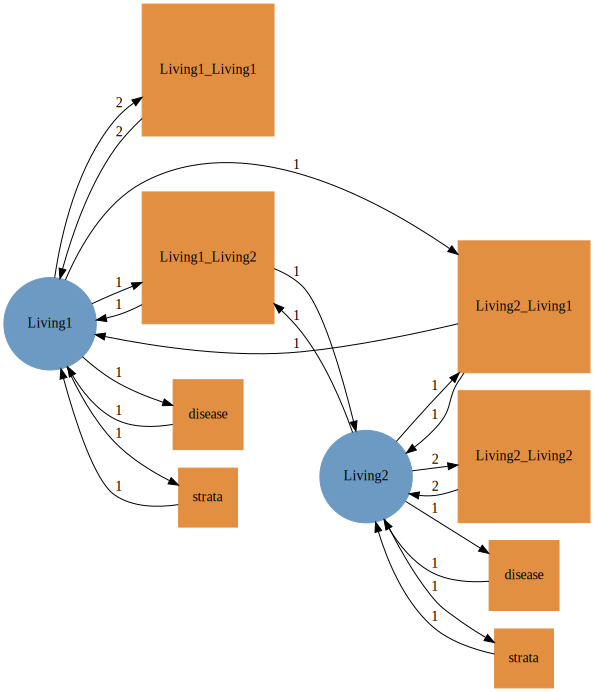

In [14]:
function living_model(n)
  typed_living = pairwise_id_typed_petri(infectious_ontology, :Pop, :infect, [Symbol("Living$(i)") for i in 1:n])
  add_reflexives(typed_living, repeat([[:disease, :strata]], n), infectious_ontology)
end

to_graphviz(dom(living_model(2)))

**Simple trip model of $N$ regions**\n
We can stratify the living model with the travel model to get a model of someone taking a simple trip.

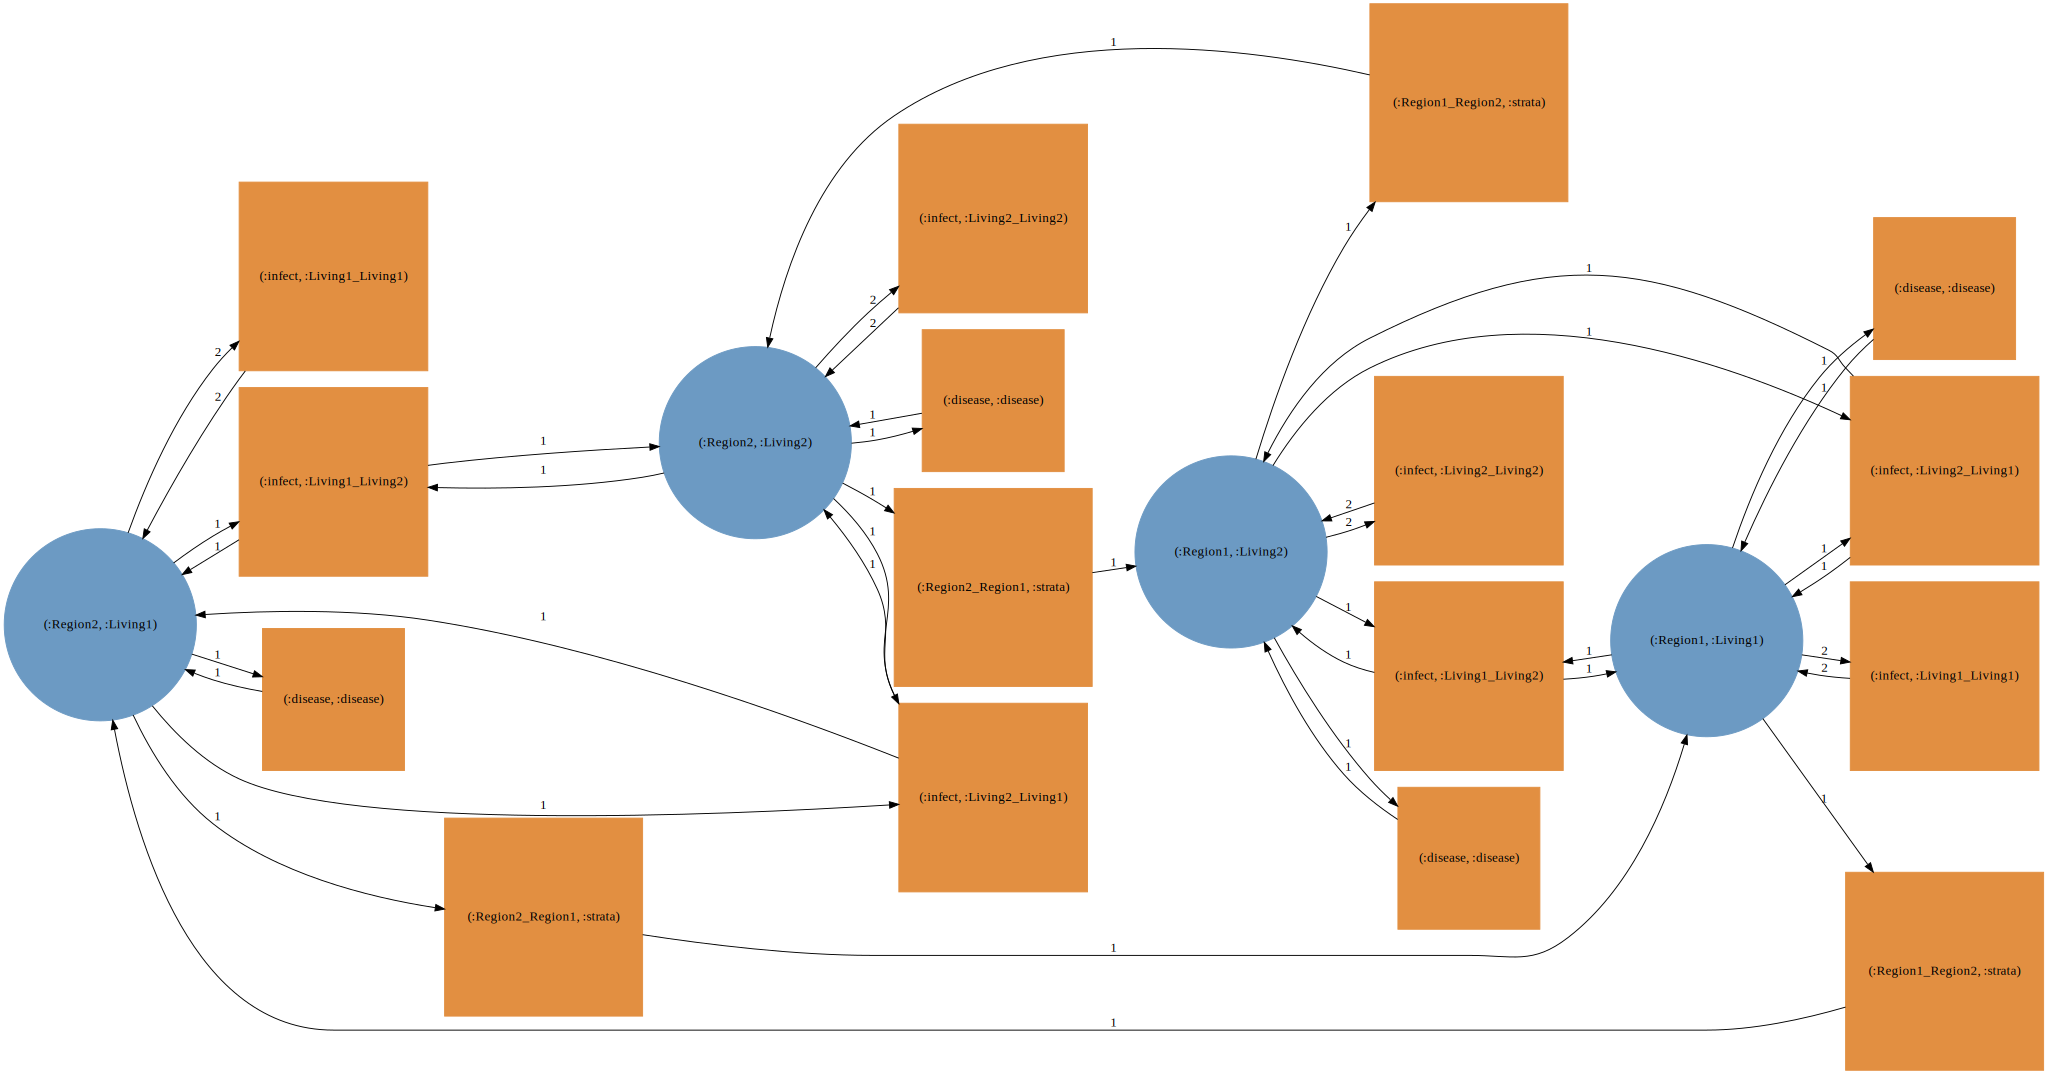

In [15]:
simple_trip_model = typed_product(travel_model(2), living_model(2))

to_graphviz(dom(simple_trip_model))

### Stratify SIRD-multi-strain and simple-trip models

Now, to stratify our multi-strain SIRD model with the simple-trip, we first retype the multi-strain model
to the `infectious_ontology` by composing with the morphism we defined.

In [16]:
sird_strain_retyped = compose(sird_strain,strain_ont_act)

ACSetTransformation((T = compose(compose(compose(FinFunction([1, 7, 16, 20, 21, 29, 30, 32, 33, 41, 42], 11, 42), FinFunction(#57, FinSet(42), FinSet(6))), FinFunction([1, 2, 2, 4, 3, 3], 6, 4)), FinFunction([1, 2, 3, 3], 4, 3)), S = compose(compose(compose(FinFunction([1, 6, 7, 8, 10, 11, 12], 7, 12), FinFunction(#57, FinSet(12), FinSet(4))), FinFunction([1, 2, 2, 2], 4, 2)), FinFunction([1, 1], 2, 1)), I = compose(compose(compose(FinFunction([1, 9, 15, 23, 33, 38, 39, 48, 49, 52, 53, 62, 63], 13, 63), FinFunction(#57, FinSet(63), FinSet(7))), FinFunction([1, 2, 3, 3, 5, 4, 4], 7, 5)), FinFunction([1, 2, 3, 4, 4], 5, 4)), O = compose(compose(compose(FinFunction([1, 9, 15, 23, 33, 38, 39, 48, 49, 52, 53, 62, 63], 13, 63), FinFunction(#57, FinSet(63), FinSet(7))), FinFunction([1, 2, 3, 3, 5, 4, 4], 7, 5)), FinFunction([1, 2, 3, 4, 4], 5, 4)), Name = Catlab.CategoricalAlgebra.FinSets.LooseVarFunction{Tuple{Symbol, Symbol}, Symbol}(FinDomFunction(Union{ACSets.ColumnImplementations.AttrVar

We can now stratify.

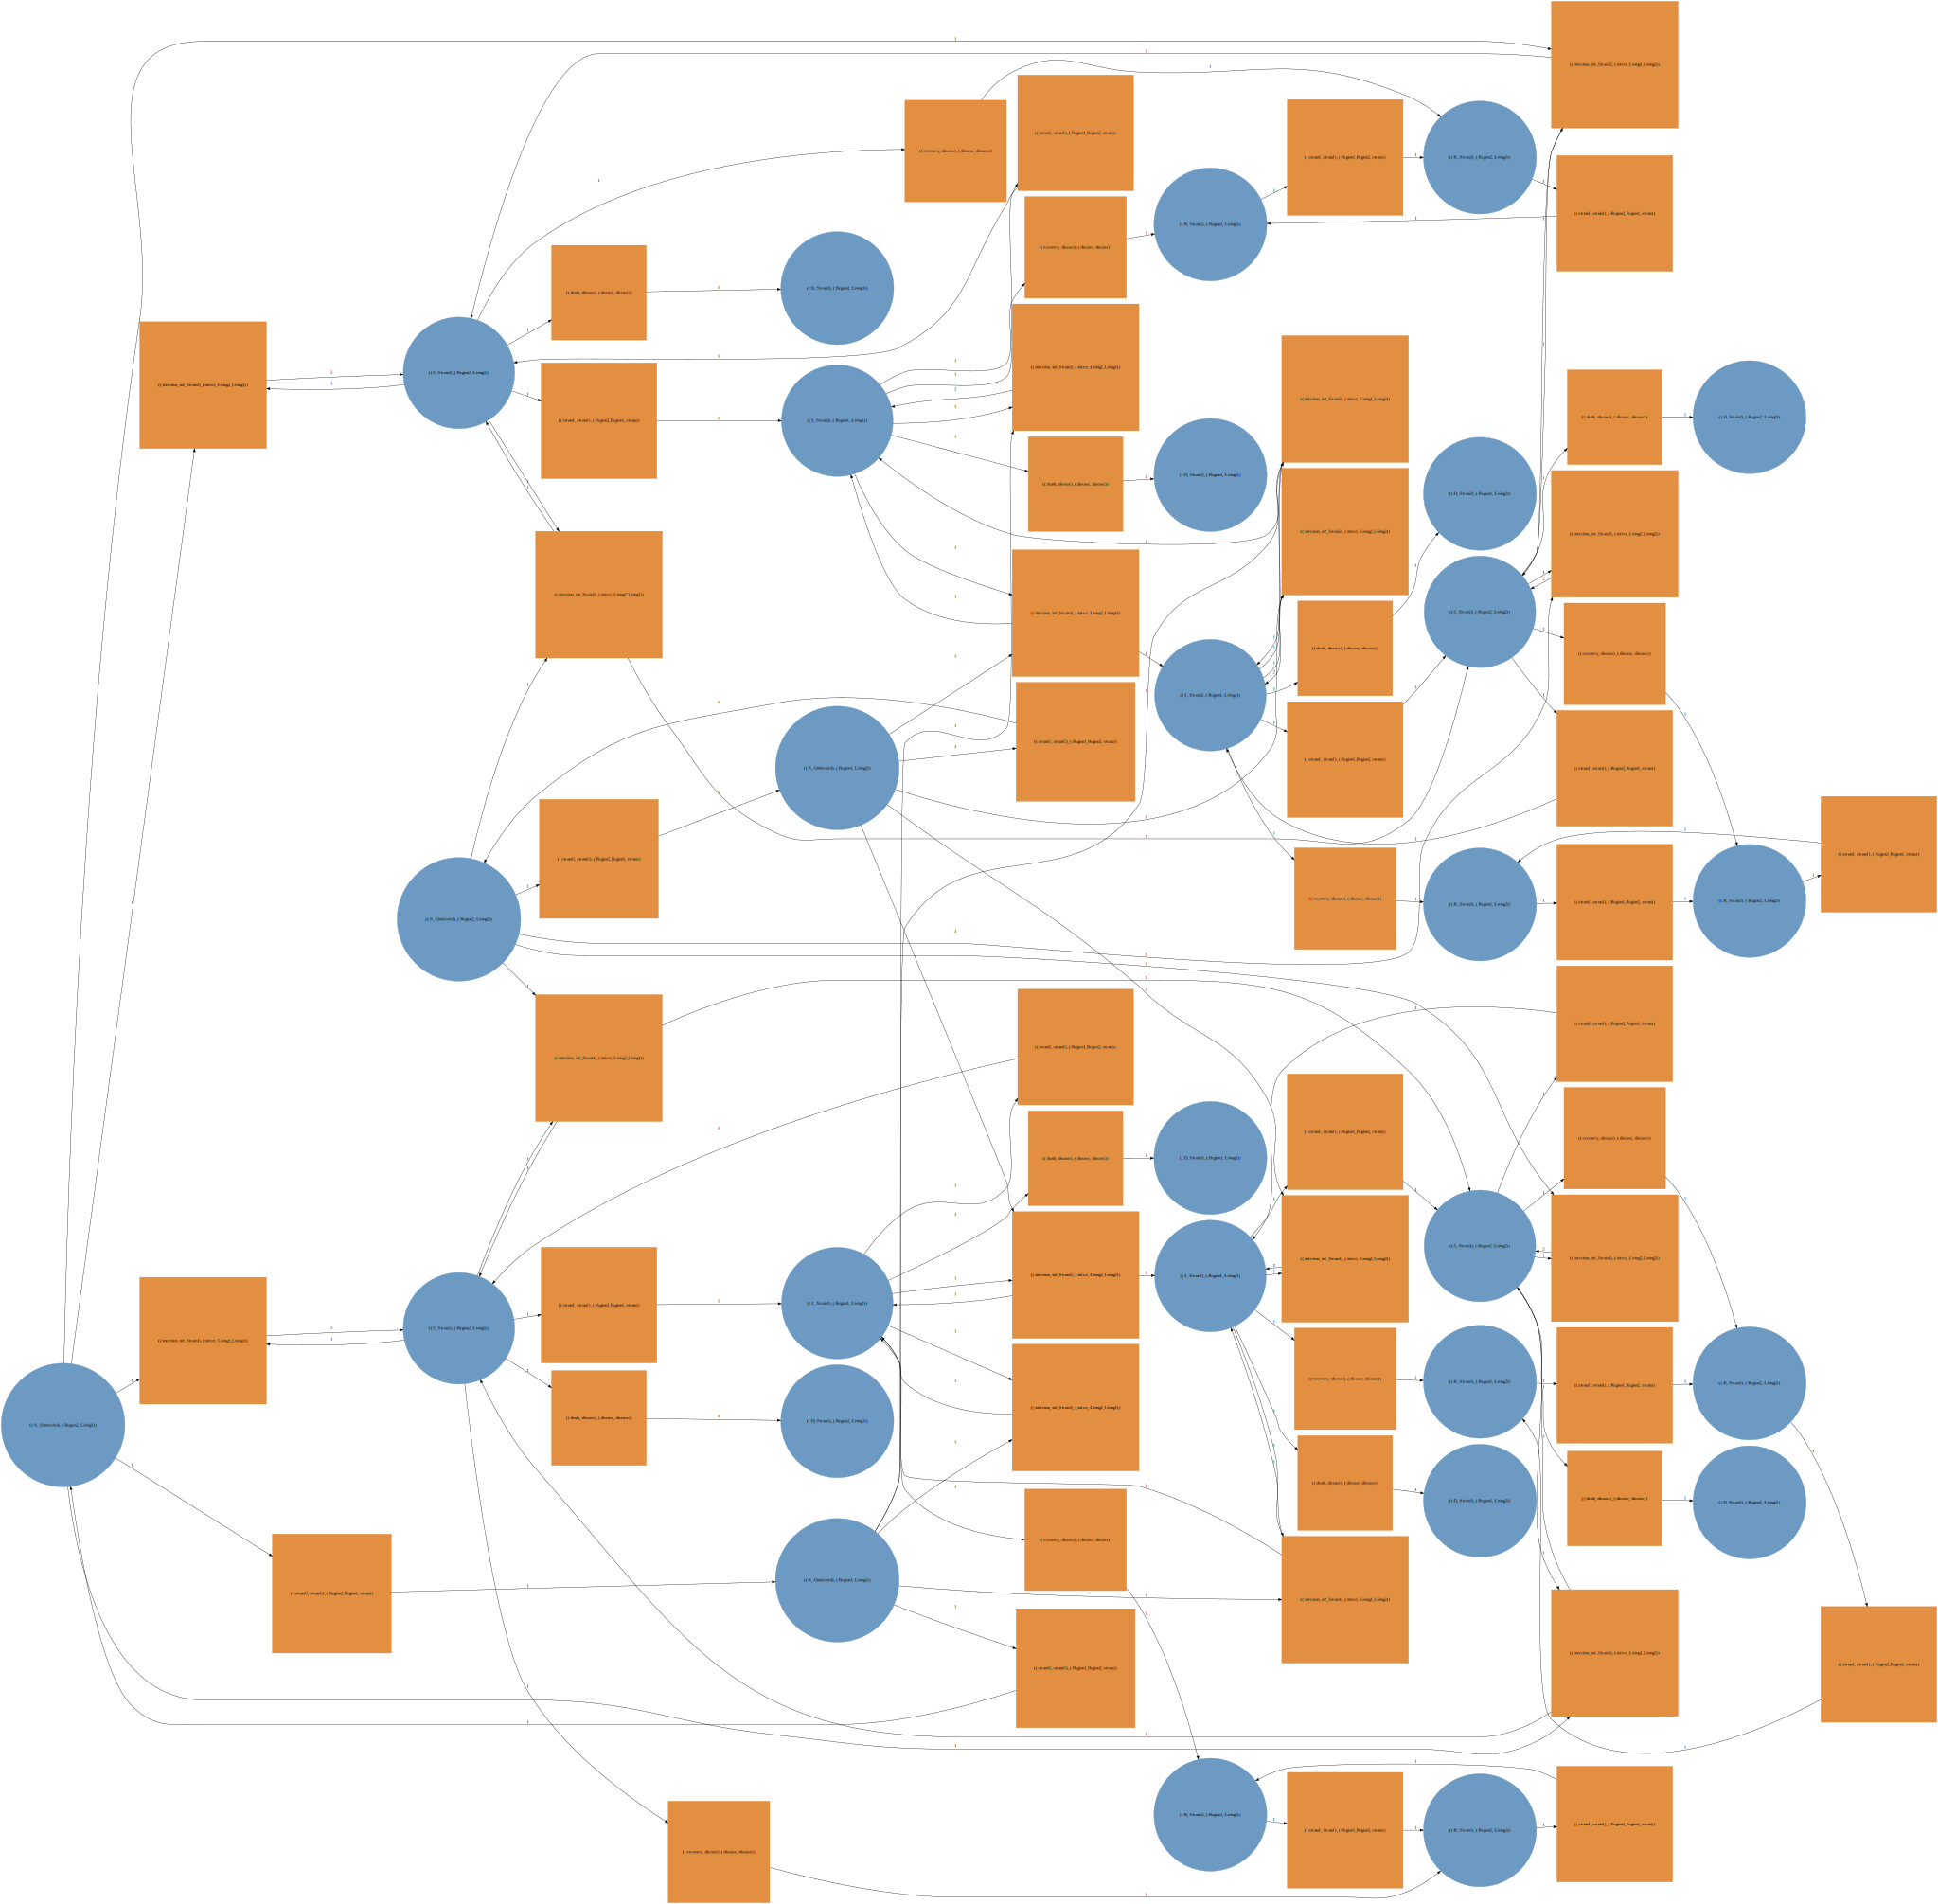

In [17]:
sird_strain_trip = typed_product(sird_strain_retyped,simple_trip_model)

to_graphviz(dom(sird_strain_trip))

## Define a multi-strain SIRD model with vaccination by multiple vaccine types

We can similarly stratify the multi-strain SIRD model with the multi-vax model.

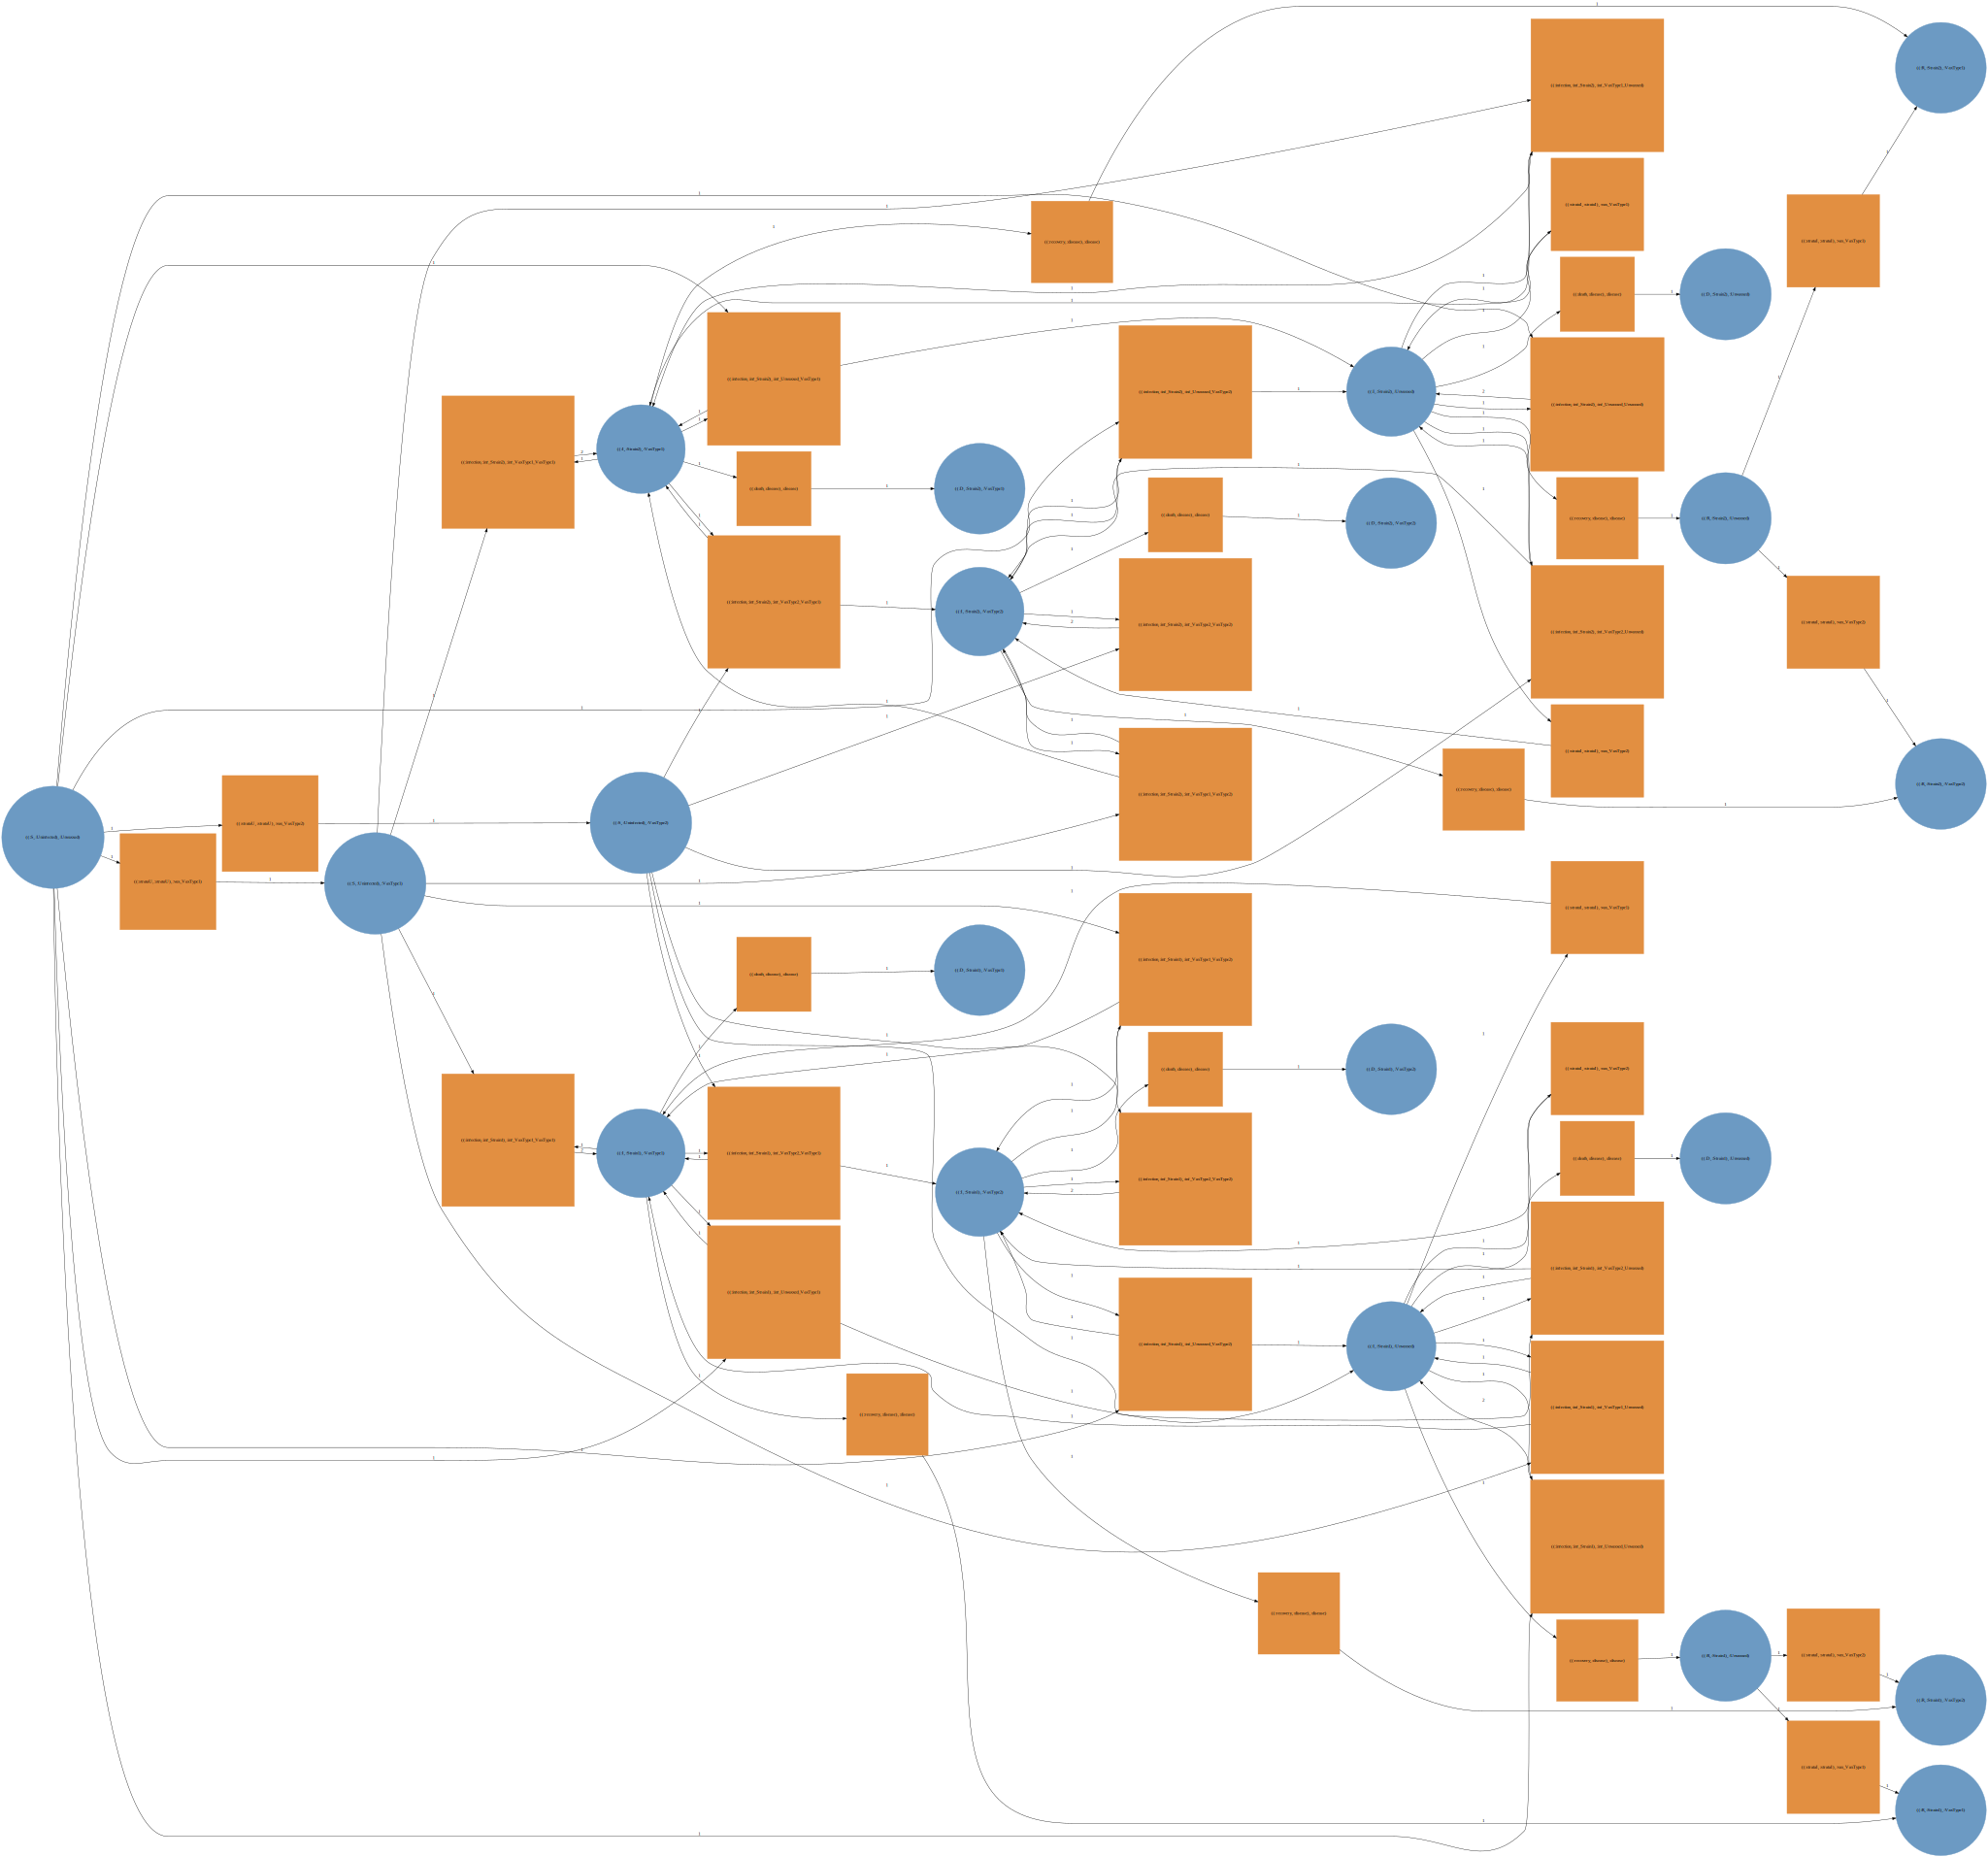

In [18]:
sird_strain_vax = typed_product(sird_strain_retyped,vax_model(2))

to_graphviz(dom(sird_strain_vax))

## Re-stratify the multi-strain multi-vax SIRD model with the simple trip model

If we would like to re-stratify our SIRD-strain-vax model with the simple trip model, we again face a difficulty.
Both the "vaccination" transitions of the first model and the "travel" transitions of the second
are currently typed to the `:strata` transition of the `infectious_ontology` type system.
To appropriately stratify, we need an additional "strata" transition to distinguish
between the two types of transitions.
We can again use post-compostion to overcome the difficulty.

### Define an augmented version of the `infectious_ontology` type system with an additional "strata" transition

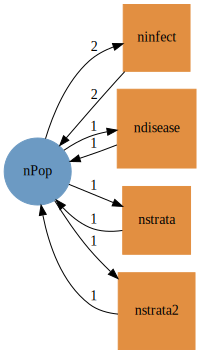

In [19]:
const aug_inf_ontology = LabelledPetriNet(
  [:nPop],
  :ninfect => ((:nPop, :nPop) => (:nPop, :nPop)),
  :ndisease => (:nPop => :nPop),
  :nstrata => (:nPop => :nPop),
  :nstrata2 => (:nPop => :nPop)
)

to_graphviz(aug_inf_ontology)

### Define morphisms from the original type system to the new augmented type system

We form one morphism that maps the `:strata` transition to `:nstrata`.
This morphism will serve to re-type the SIRD-strain-vax model.

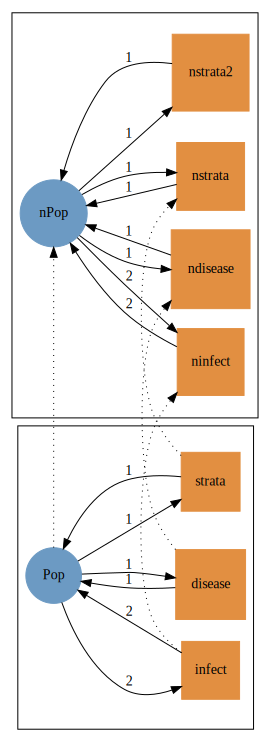

In [20]:
function retype_inf_ont(strata_map)
  uwd = RelationDiagram([:nPop])
  variable = :Pop
  junction = add_junction!(uwd, :nPop, variable=variable)
  port = ports(uwd, outer=true)[1]
  set_junction!(uwd, port, junction, outer=true)
  junctions = Dict(variable => junction)

  boxes = [:ninfect, :ndisease, strata_map]
  for bname in boxes
    if bname == :ninfect
      pair = (:Pop, :Pop, :Pop, :Pop)
    else
      pair = (:Pop, :Pop)
    end
    box = add_box!(uwd, [junction_type(uwd, junctions[p]) for p in pair], name=bname)
    for (rgn, port) in zip(pair, ports(uwd, box))
      set_junction!(uwd, port, junctions[rgn])
    end
  end

  act = oapply_typed(aug_inf_ontology, uwd, [:infect, :disease, :strata])
end

inf_ont_act = retype_inf_ont(:nstrata)

to_graphviz(inf_ont_act)

We form another morphism that maps the `:strata` transition to `:nstrata2`.
This morphism will serve to re-type the simple trip model.

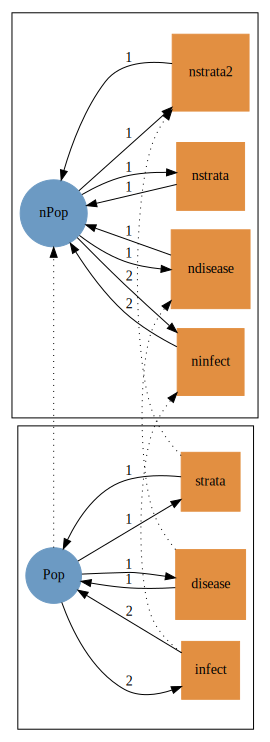

In [21]:
rgn_ont_act = retype_inf_ont(:nstrata2)

to_graphviz(rgn_ont_act)

### Add reflexive transitions

To finish preparing for stratification, we need to add the new reflexive transitions to the component models.
To the SIRD-strain-vax model, we add an `:nstrata2` tranisiton to each state that does not represent
a portion of the population that is deceased (because deceased individuals cannot travel).

In [22]:
sird_strain_vax_retyped = flatten_labels(compose(sird_strain_vax,inf_ont_act))
reflx = [[:nstrata2]]
for ii in 2:ns(dom(sird_strain_vax_retyped))
  if split(String(dom(sird_strain_vax_retyped)[ii,:sname]),"_")[1] == "D"
    push!(reflx,[])
  else
    push!(reflx,[:nstrata2])
  end
end
aug_sird_strain_vax = add_reflexives(sird_strain_vax_retyped, reflx, aug_inf_ontology);

To the simple trip model, we add an `:nstrata` tranisiton for each state.

In [23]:
simple_trip_retyped = flatten_labels(compose(simple_trip_model,rgn_ont_act))
aug_trip = add_reflexives(simple_trip_retyped, repeat([[:nstrata]],ns(dom(simple_trip_retyped))), aug_inf_ontology);

### Stratify the SIRD-strain-vax and simple trip models

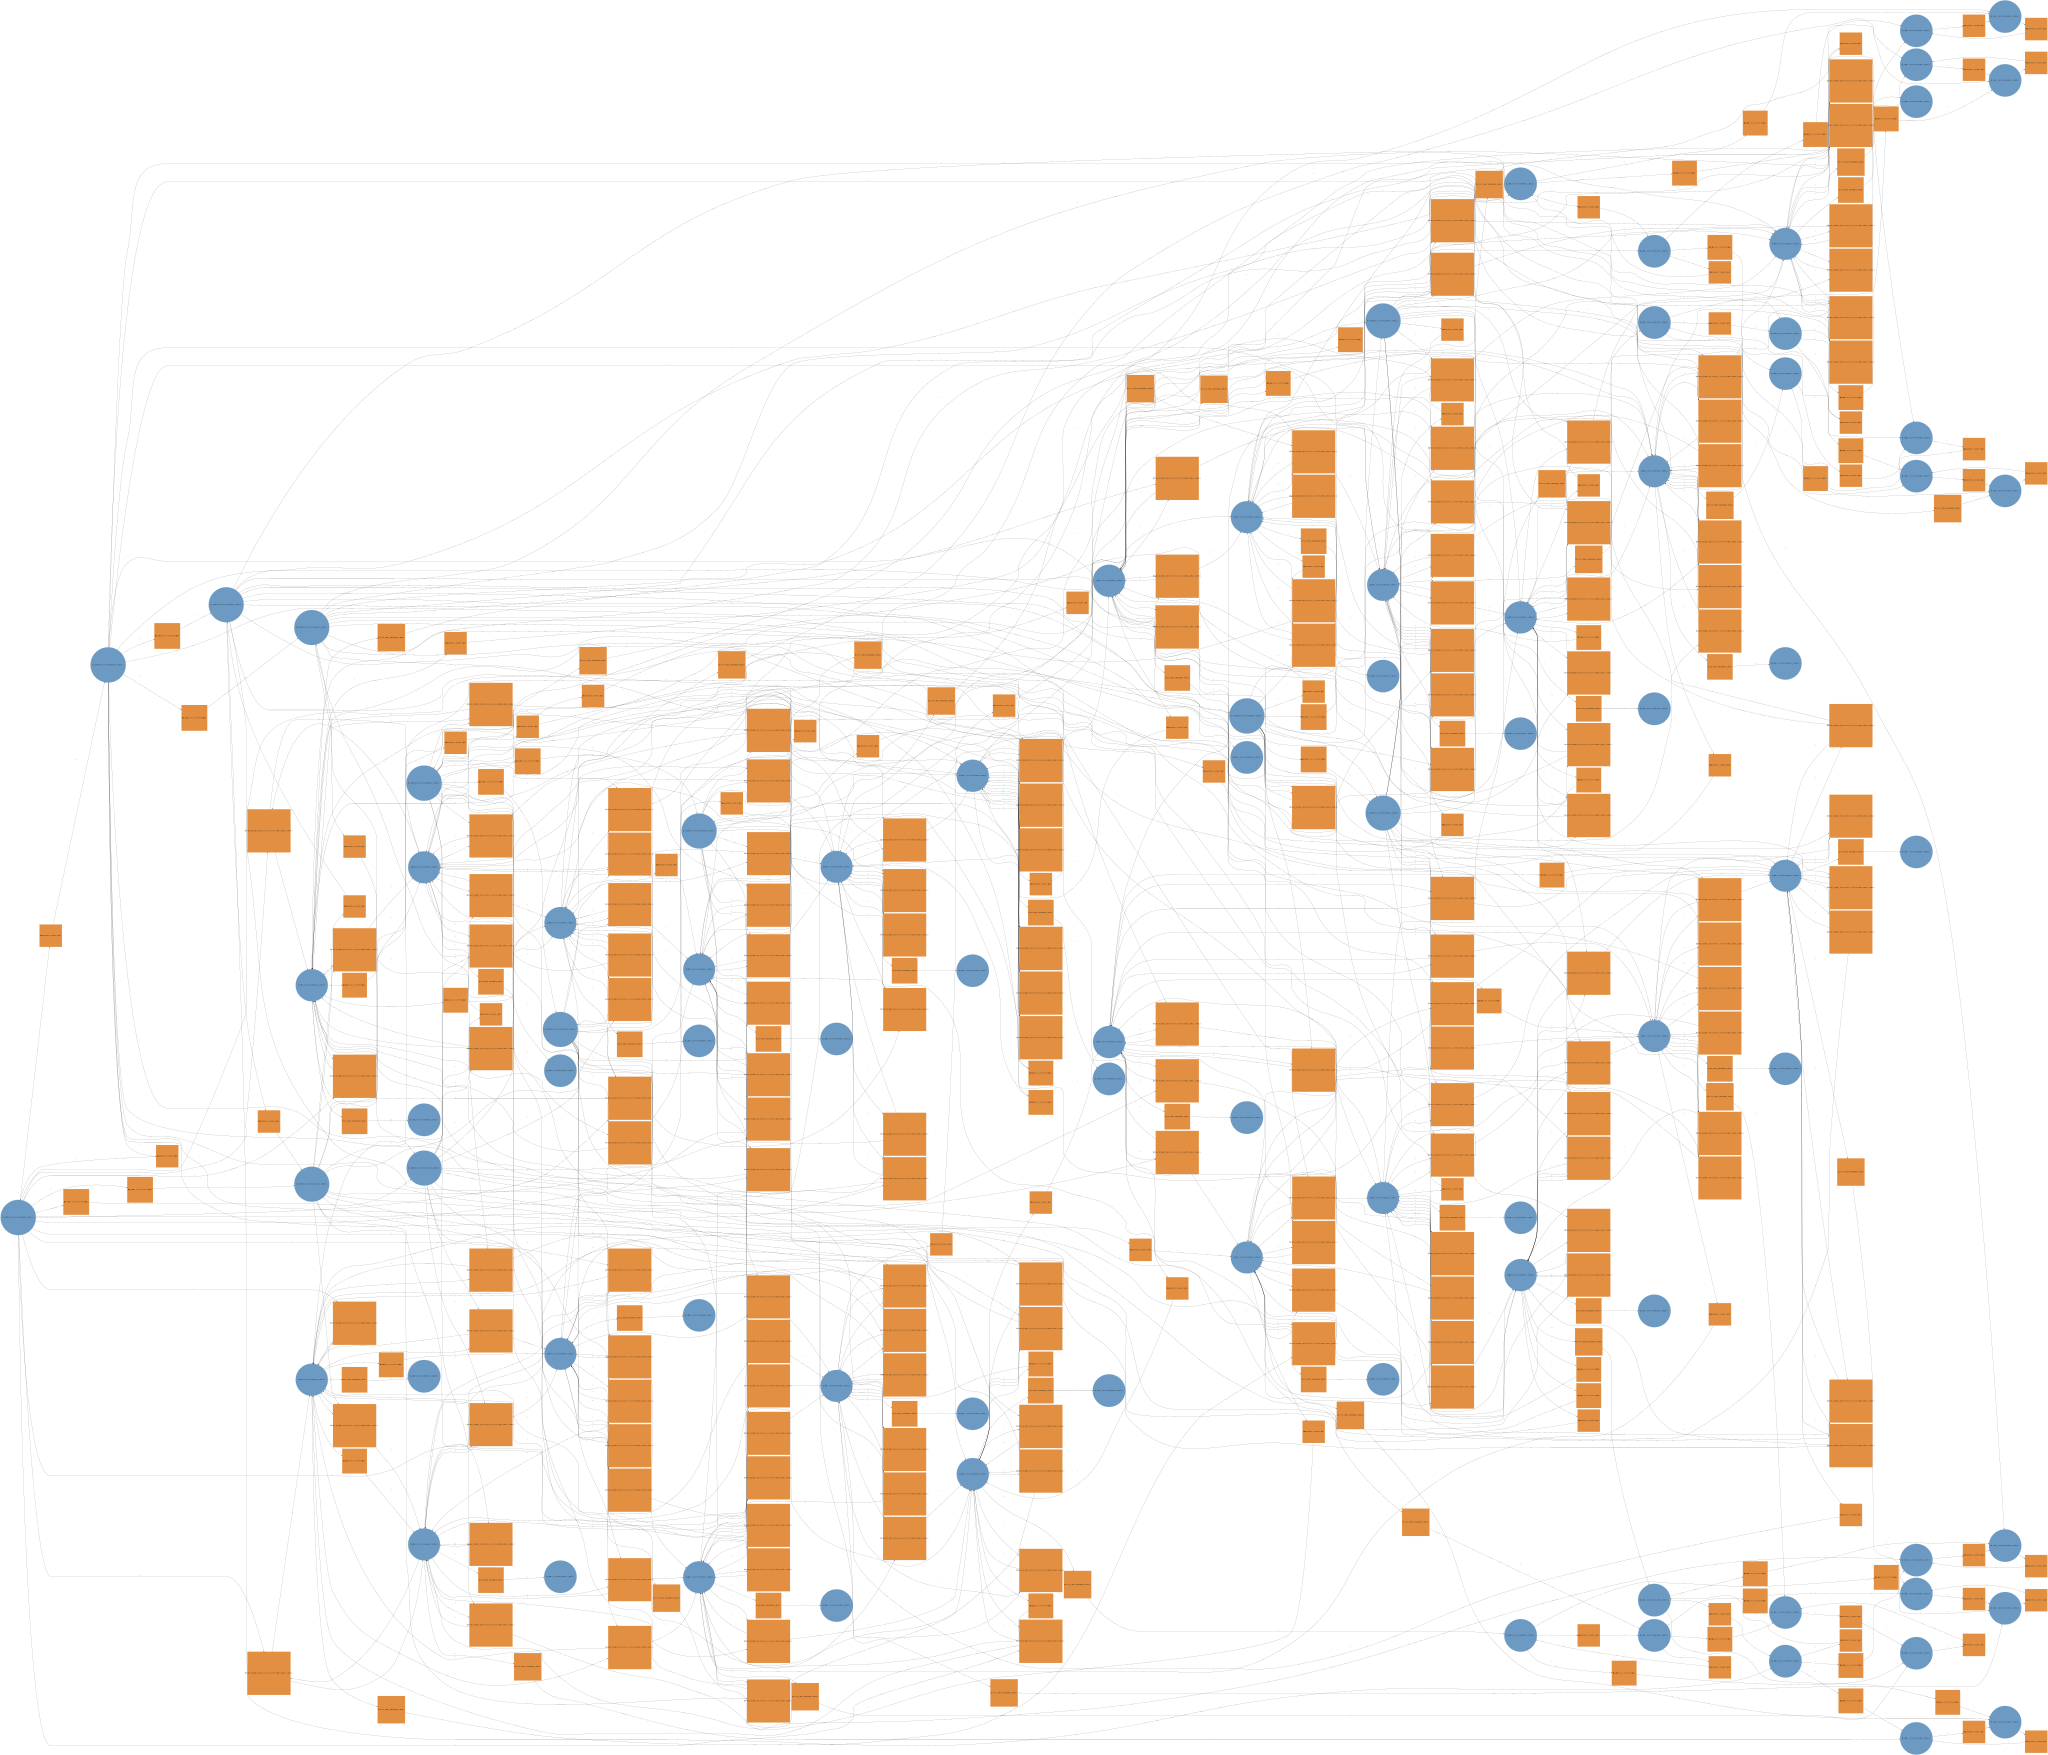

In [24]:
sird_strain_vax_trip = typed_product([aug_sird_strain_vax,aug_trip])

to_graphviz(dom(sird_strain_vax_trip))